# Image segmentation with the Watershed method 

In this notebook, we propose to apply a well-known segmentation method based on classic image processing techniques rather than machine learning. The aim is to familiarise ourselves with the problem of image segmentation and to see how this type of baseline method performed for this problem, before the appearance of deep learning methods.

The method we will use is named Watershed (https://en.wikipedia.org/wiki/Watershed_(image_processing).

## Principle of image segmentation

Image segmentation is the process of partitioning a digital image into multiple segments (sets of pixels, also known as superpixels). The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

We give below an example of image segmentations from a well-known benchmark dataset that contains celebrity portrait images. The goal here is to separate the different part of the face in the image (eyes, nose, mouth, etc.).

![celebahq.png](./celebahq.png)  

*source: https://github.com/tkarras/progressive_growing_of_gans*

The state-of-the-art methods for such image segmentation tasks are now based on deep learning methods. However, before the appearance of these methods, several image processing methods were used to segment images, with more or less satisfactory results. One of these methods is the Watershed method, which we will present in this notebook.

## Principle of the Watershed method
To understand the principle of this method, imagine that a grayscale image is a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. Imagine now that we start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors, will start to merge. To avoid that, we build barriers in the locations where water merges. We continue the work of filling water and building barriers until all the peaks are underwater. Then the barriers we built gives us the segmentation result.

This method is known to give oversegmented result due to noise or any other irregularities in the image. It is usually better suited for dividing images into adjacent regions of interest rather than detecting isolated shapes. One way to mitigate this issue is to use markers to guide the watershed algorithm to segment the image. These markers can be obtained from the image itself or from external sources. In the following, we will use some basic morphological transformations of the image to obtain the markers, corresponding to regions of the images that are likely to contain objects.

## Environment setup and data preparation
To apply the watershed method, we are going to rely on the `OpenCV` python library, an open-source library that contains implementations of several hundred computer vision methods. We will also use the `matplotlib` library to display the images, the `numpy` library for some basic operations in python and the `os` library to access the various image files we will be using.

In [115]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os

We now need to prepare the images we want to segment. In the following, we propose to use the EMPS dataset, a collection of 465 electron microscopy images and their corresponding pixel-level semantic instance segmentations (https://github.com/by256/emps). 

The following python scripts require to download the dataset beforehand and to extract the images and masks in the `emps/images` and `emps/segmaps` directories respectively.

In [116]:
images_directory = 'emps/images/'
masks_directory = 'emps/segmaps/'

We create now a list of the images and masks files and load one of them to see what they look like.

In [117]:
def list_files(img_dir, msk_dir):
    """ List images and masks files from the given directories """
    # the os.listdir function lists the files in a directory but does not sort them. Thus, we need to sort the list to have the images and masks in the same order.
    images_list = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".png")])
    masks_list = sorted([os.path.join(msk_dir, fname) for fname in os.listdir(msk_dir) if fname.endswith(".png")])
    return images_list, masks_list

# Check that we have the same number of images and masks and that they are sorted in the same order
images_list, masks_list = list_files(images_directory, masks_directory)
print(f"Number of images: {len(images_list)}")
print(images_list[0:5])
print(f"Number of masks: {len(masks_list)}")
print(masks_list[0:5])

Number of images: 465
['emps/images/00655d9628.png', 'emps/images/0113230c21.png', 'emps/images/0144266d21.png', 'emps/images/01ac659240.png', 'emps/images/027f25010a.png']
Number of masks: 465
['emps/segmaps/00655d9628.png', 'emps/segmaps/0113230c21.png', 'emps/segmaps/0144266d21.png', 'emps/segmaps/01ac659240.png', 'emps/segmaps/027f25010a.png']


(512, 772, 3)


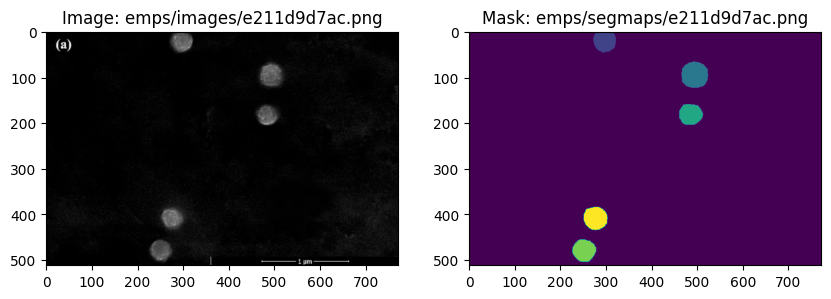

In [118]:
def list_to_arrays(img_list, msk_list):
    """Load images and masks from the given lists and return them as arrays"""
    images = [cv.imread(image, cv.IMREAD_UNCHANGED) for image in img_list]
    masks = [cv.imread(mask, cv.IMREAD_UNCHANGED) for mask in msk_list]
    return images, masks

images, masks = list_to_arrays(images_list, masks_list)
idx = 400 # let's take the 400th image (almost at random)
print(images[idx].shape)
# print(images[idx]) # uncomment to see the pixel values

# Display the image and the mask using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[idx])
plt.title(f"Image: {images_list[idx]}")
plt.subplot(1, 2, 2)
plt.imshow(masks[idx])
plt.title(f"Mask: {masks_list[idx]}")
plt.show()

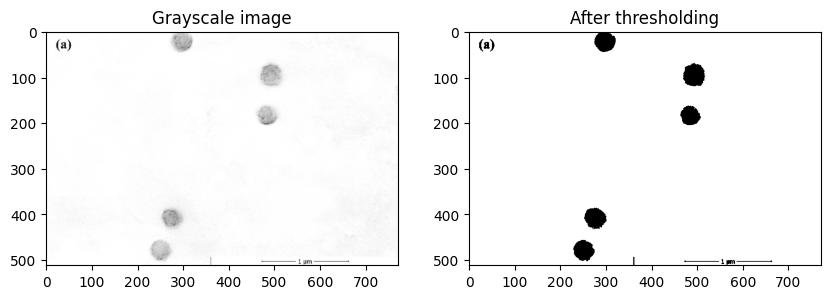

In [119]:
def otsu_binarization(img):
    # Image binarization by converting to grayscale and applying Otsu's' thresholding
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    return gray, thresh

gray, thresh = otsu_binarization(images[idx])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='Greys')
plt.title("Grayscale image")
plt.subplot(1, 2, 2)
plt.imshow(thresh, cmap='Greys')
plt.title("After thresholding")
plt.show()

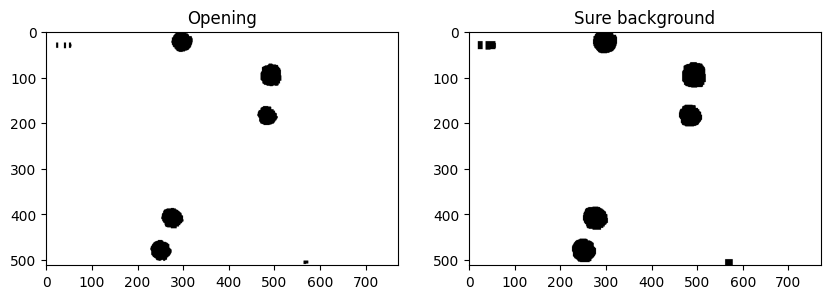

In [120]:
def morpho_background(thresh):
    # detect regions of the images that are 'sure' background by noise removal 
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations=2)
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    return opening, sure_bg

opening, sure_bg = morpho_background(thresh)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(opening, cmap='Greys')
plt.title("Opening")
plt.subplot(1, 2, 2)
plt.imshow(sure_bg, cmap='Greys')
plt.title("Sure background")
plt.show()

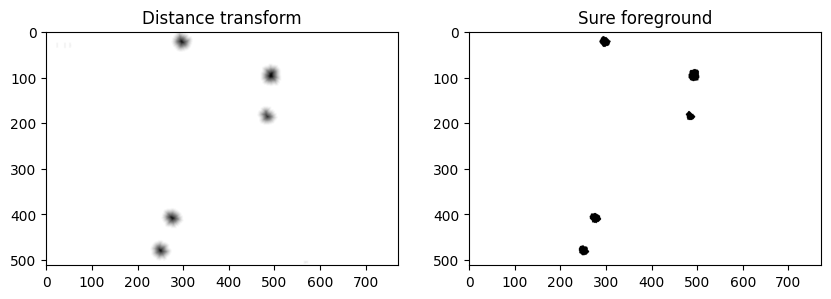

In [121]:
def morpho_foreground(opening, lam=0.5):
    # detect regions of the images that are 'sure' foreground by distance transform and thresholding
    # Note: the 'lam' parameter is used to adjust the threshold value (instead of using Otsu's method)
    #       lam=0.5 means that the threshold is set to 50% of the maximum distance transform value
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    _, sure_fg = cv.threshold(dist_transform, lam * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    return dist_transform, sure_fg

dist_transform, sure_fg = morpho_foreground(opening)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dist_transform, cmap='Greys')
plt.title("Distance transform")
plt.subplot(1, 2, 2)
plt.imshow(sure_fg, cmap='Greys')
plt.title("Sure foreground")
plt.show()

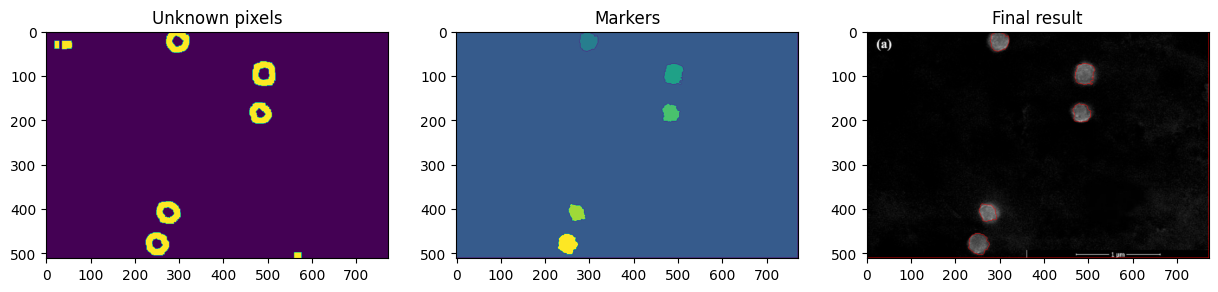

In [122]:
def watershed(image, sure_fg, sure_bg):
    unknown = cv.subtract(sure_bg, sure_fg)
    _, markers = cv.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]
    return image, markers, unknown

img_w, markers, unknown = watershed(images[idx], sure_fg, sure_bg)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(unknown)
plt.title("Unknown pixels")
plt.subplot(1, 3, 2)
plt.imshow(markers)
plt.title("Markers")
plt.subplot(1, 3, 3)
plt.imshow(img_w)
plt.title("Final result")
plt.show()

## More test with the Watershed method

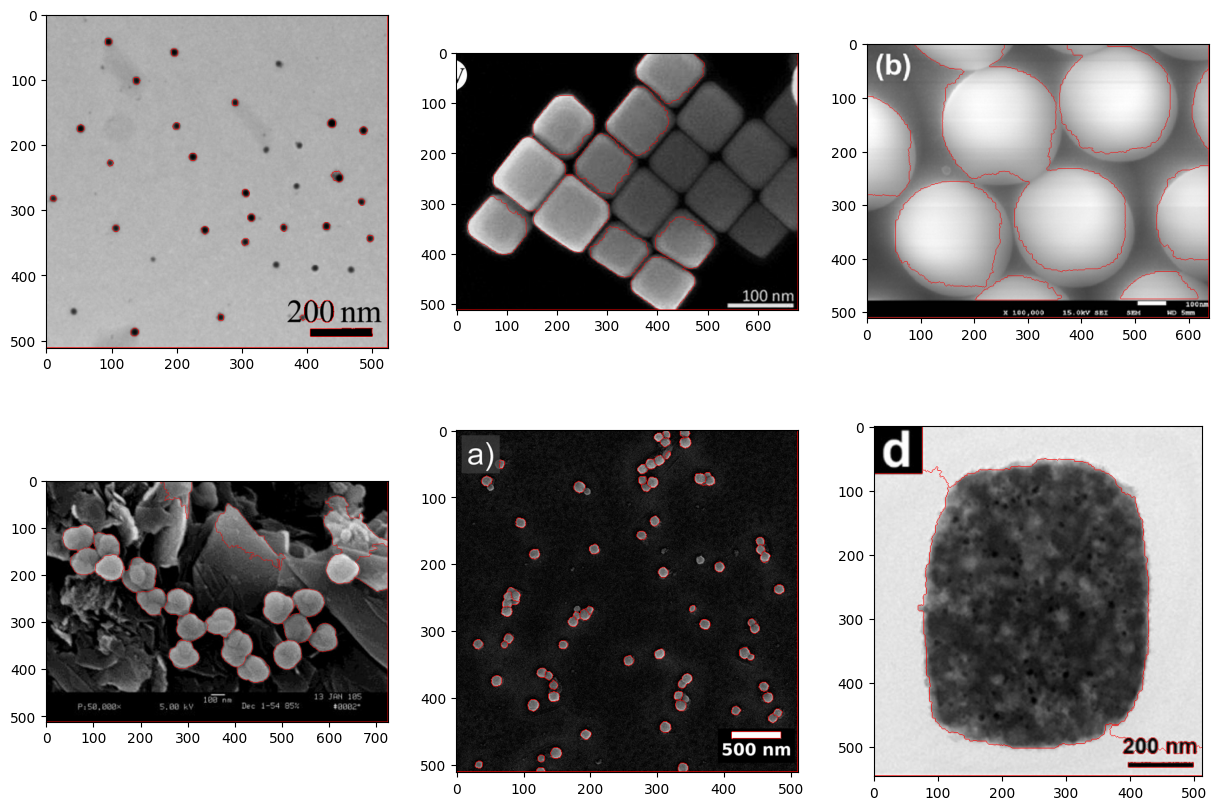

In [123]:
def watershed_pipeline(image, lam=0.5):
    gray, thresh = otsu_binarization(image)
    opening, sure_bg = morpho_background(thresh)
    dist_transform, sure_fg = morpho_foreground(opening, lam)
    img_w, markers, unknown = watershed(image, sure_fg, sure_bg)
    return img_w

exple1 = watershed_pipeline(images[11], lam=0.8)
exple2 = watershed_pipeline(images[33], lam=0.6)
exple3 = watershed_pipeline(images[42], lam=0.07)
exple4 = watershed_pipeline(images[112])
exple5 = watershed_pipeline(images[222])
exple6 = watershed_pipeline(images[404], lam=0.2)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(exple1)
plt.subplot(2, 3, 2)
plt.imshow(exple2)
plt.subplot(2, 3, 3)
plt.imshow(exple3)
plt.subplot(2, 3, 4)
plt.imshow(exple4)
plt.subplot(2, 3, 5)
plt.imshow(exple5)
plt.subplot(2, 3, 6)
plt.imshow(exple6)
plt.show()

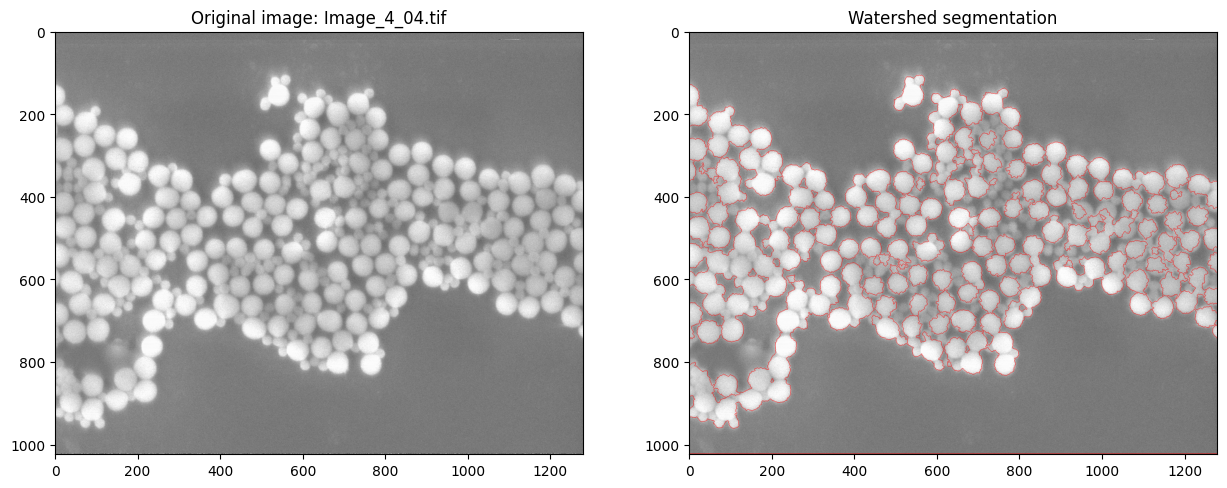

In [127]:
folder_name = './Images/CEA2_MEB'
image_name = "Image_4_04.tif"
image_path = os.path.join(folder_name, image_name)
image = cv.imread(image_path, cv.IMREAD_UNCHANGED)  
if len(image.shape) == 2: # Convert image to RGB if it is in grayscale
    image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
image_seg = watershed_pipeline(image.copy(), lam=0.2) # Note: work on a copy of the image to avoid modifying the original image

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f"Original image: {image_name}")
plt.subplot(1, 2, 2)
plt.imshow(image_seg)
plt.title(f"Watershed segmentation")
plt.show()